In [1]:
import xarray as xr
import numpy as np
from dask.distributed import Client, wait

In [2]:
client = Client(n_workers=1, threads_per_worker=3, memory_limit=3e9, ip="127.0.0.1")
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 1
Total threads: 3,Total memory: 2.79 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46007,Workers: 1
Dashboard: http://127.0.0.1:8787/status,Total threads: 3
Started: Just now,Total memory: 2.79 GiB
Comm: tcp://127.0.0.1:38549,Total threads: 3
Dashboard: http://127.0.0.1:37997/status,Memory: 2.79 GiB
Nanny: tcp://127.0.0.1:46137,


In [3]:
ds = xr.Dataset(
    {
        "A": (("t", "y", "x"), np.random.normal(0, 1, size=(73, 180, 360)) + np.linspace(0, 2, 360)),
        "B": (("t", "y", "x"), np.random.normal(0, 1, size=(73, 180, 360)) + np.linspace(0, 3, 180)[:, np.newaxis]),
    }
)
ds

<xarray.Dataset>
Dimensions:  (t: 73, y: 180, x: 360)
Dimensions without coordinates: t, y, x
Data variables:
    A        (t, y, x) float64 -0.9118 -0.08833 0.4414 ... 2.504 2.619 1.775
    B        (t, y, x) float64 -0.1026 0.9768 0.2363 ... 1.64 3.42 3.063

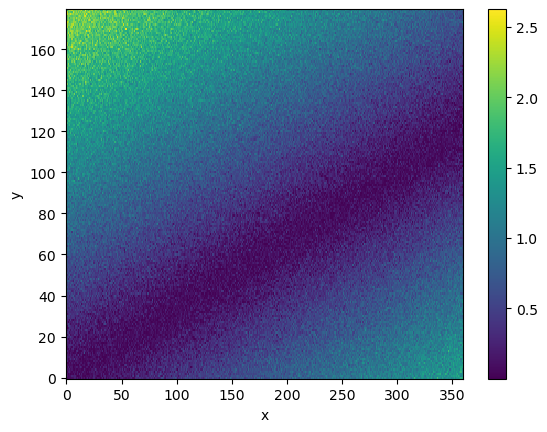

In [4]:
(
    abs(ds.A.mean("t") - ds.B.mean("t"))
    / (ds.A.var("t") + ds.B.var("t")) ** 0.5
).plot()

In [5]:
ds.to_netcdf("AB.nc")

In [6]:
!ls -lah AB.nc

-rw-r--r-- 1 jovyan jovyan 73M Aug  8 14:38 AB.nc


In [7]:
ds = xr.open_dataset("AB.nc", chunks={"t": -1, "y": 30, "x": 60})
ds

<xarray.Dataset>
Dimensions:  (t: 73, y: 180, x: 360)
Dimensions without coordinates: t, y, x
Data variables:
    A        (t, y, x) float64 dask.array<chunksize=(73, 30, 60), meta=np.ndarray>
    B        (t, y, x) float64 dask.array<chunksize=(73, 30, 60), meta=np.ndarray>

In [8]:
ds_bootstrapped = xr.concat(
    (
        (
            ds.isel(t=(
                ("it0", "iteration"),
                np.random.randint(ds.dims["t"], size=(ds.dims["t"], 33))
            ))
        ).rename({"it0": "t"})
        for n in range(66)
    ),
    dim="iteration",
)

ds_bootstrapped

<xarray.Dataset>
Dimensions:  (t: 73, iteration: 2178, y: 180, x: 360)
Dimensions without coordinates: t, iteration, y, x
Data variables:
    A        (t, iteration, y, x) float64 dask.array<chunksize=(73, 33, 30, 60), meta=np.ndarray>
    B        (t, iteration, y, x) float64 dask.array<chunksize=(73, 33, 30, 60), meta=np.ndarray>

In [9]:
ds_bootstrapped_mean = ds_bootstrapped.mean("t").mean("iteration")
ds_bootstrapped_std = ds_bootstrapped.mean("t").std("iteration")

In [10]:
%%time

ds_bootstrapped_mean = ds_bootstrapped_mean.compute()

/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py:3106: UserWarning: Sending large graph of size 54.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 1min 41s, sys: 9.22 s, total: 1min 51s
Wall time: 7min 35s


In [11]:
%%time

ds_bootstrapped_std = ds_bootstrapped_std.compute()

CPU times: user 1min 41s, sys: 8.99 s, total: 1min 50s
Wall time: 7min 49s


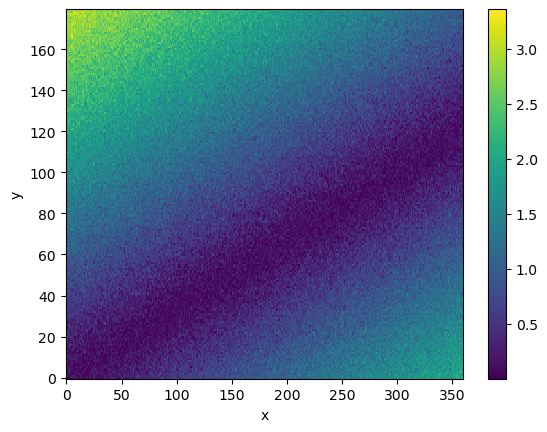

In [12]:
abs(ds_bootstrapped_mean.A - ds_bootstrapped_mean.B).plot()

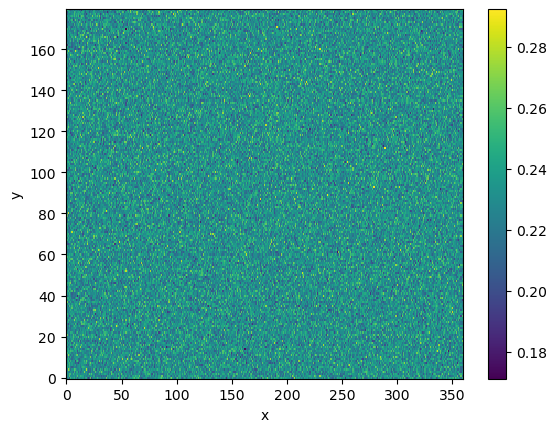

In [13]:
(ds_bootstrapped_std.A + ds_bootstrapped_std.B).plot()

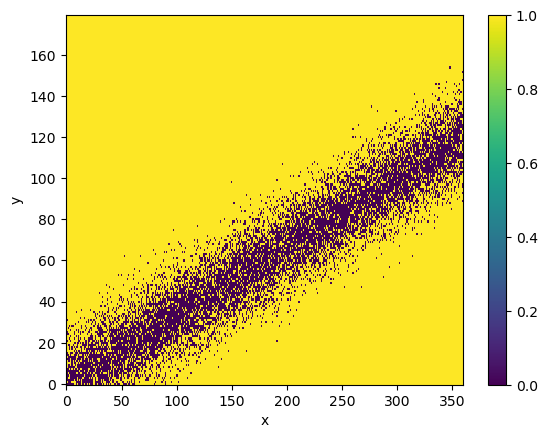

In [14]:
(
    abs(ds_bootstrapped_mean.A - ds_bootstrapped_mean.B)
    > (ds_bootstrapped_std.A + ds_bootstrapped_std.B)
).plot()